# modesto tutorial

This tutorial shows how to let modesto solve a simple network.

## Imports and other stuff

In [49]:
from __future__ import division

import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto

In [50]:
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('Main.py')

## Network graph

A first step is to make a networkX object of the network you would like to optimize:

For the model to load correctly into modesto, you need to add some attributes to each of the nodes and edges.

For the nodes:
* **Name of the node**
* **x, y, and z**: coordinates of the node in meter
* **comps**: a dictionary containing all components (except the network pipes) that are connected to the nodes. The keys of the dictionary are the names of the components, the values are the types of the components.

For the edges:
* **Name of the node where the edge starts**
* **Name of the node where the ends**
* **Name of the edge**
    

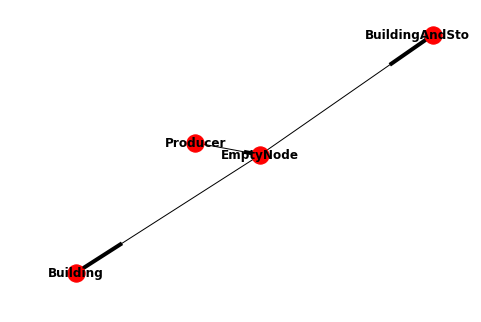

In [51]:
G = nx.DiGraph()

G.add_node('Producer', x=4000, y=4000, z=0,
           comps={'plant': 'ProducerVariable'})
G.add_node('EmptyNode', x=2600, y=5000, z=0,
           comps={})
G.add_node('BuildingAndStorage', x=2500, y=4600, z=0,
           comps={'building': 'RCmodel',
                  'storage': 'StorageVariable'
                  }
           )
G.add_node('Building', x=2000, y=5500, z=0,
           comps={'building': 'RCmodel'})

G.add_edge('Producer', 'EmptyNode', name='pipe1')
G.add_edge('EmptyNode', 'BuildingAndStorage', name='pipe2')
G.add_edge('EmptyNode', 'Building', name='pipe3')
    
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

## Setting up modesto

1) Decide the following characteristics of the optimization problem:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp). Currently, weather and prixe data for 2014 are available in modesto.
* **Pipe model**: The type of model used to model the pipes. Only one type can be selected for the whole optimization problem (unlike the component model types).

In [52]:
horizon = 5*24*3600
time_step = 3600
start_time = pd.Timestamp('20140104')
pipe_model = 'SimplePipe'

2) Create a modesto object

In [53]:
optmodel = Modesto(horizon=horizon, 
                   time_step=time_step,
                   pipe_model=pipe_model, 
                   graph=G,
                   start_time=start_time)

02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter Te
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
02-13 15:16 modesto.Node                         INFO     Initializing Node Building
02-13 15:16 modesto.component.Component          INFO     Initializing Component building
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TiD0
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TflD0
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TwiD0
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TwD0
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TfiD0
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TiN0
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter TwiN0
02-13 15:16 modesto.parameter.Parameter          IN

02-13 15:16 modesto.component.Component          INFO     Initializing Component pipe3
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter pipe_type
02-13 15:16 modesto.Edge                         INFO     Pipe model SimplePipe added to pipe3
02-13 15:16 modesto.Edge                         INFO     Initializing Edge pipe2
02-13 15:16 modesto.component.Component          INFO     Initializing Component pipe2
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter pipe_type
02-13 15:16 modesto.Edge                         INFO     Pipe model SimplePipe added to pipe2
02-13 15:16 modesto.Edge                         INFO     Initializing Edge pipe1
02-13 15:16 modesto.component.Component          INFO     Initializing Component pipe1
02-13 15:16 modesto.parameter.Parameter          INFO     Initializing Parameter pipe_type
02-13 15:16 modesto.Edge                         INFO     Pipe model SimplePipe added to pipe1


## Adding data

modesto is now aware of the position and interconnections between components, nodes and edges, but does not have any information yet rergarding, weahther, prices, customer demands, component sizing, etc.


### Collect data

modesto provides some useful data handling methods (found in modesto.utils). Most notable is read_time_data, that can load data from a csv file.

#### Weather data:

In [54]:
t_amb = ut.read_time_data('../Data/Weather', name='weatherData.csv')['Te']
t_g = ut.read_time_data('../Data/Weather', name='weatherData.csv')['Tg']
QsolN = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolN']
QsolE = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolS']
QsolS = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolN']
QsolW = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolW']

#### Building data

In [55]:
day_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['day_max']
day_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['day_min']
night_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['night_max']
night_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['night_min']
bathroom_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['bathroom_max']
bathroom_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['bathroom_min']
floor_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['floor_max']
floor_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['floor_min']
Q_int_D = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['Q_int_D']
Q_int_N = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['Q_int_N']

#### Electricity price

In [56]:
c_f = ut.read_time_data(path='../Data/ElectricityPrices',name='DAM_electricity_prices-2014_BE.csv')['price_BE']

### Changing parameters

In order to solve the problem, all parameters need to be filled. A list of all required parameters and their description can be found with the following command:

In [57]:
optmodel.print_all_params()


--- Building.building ---

-TfiN0
Description: Begin temperature at state TfiN
Unit: K
InitType: fixedVal 
Upper bound: None 
Lower bound: None 
Slack: True

-Q_sol_W
Description: Western solar radiation
Unit: W

-Q_sol_S
Description: Southern solar radiation
Unit: W

-Q_sol_N
Description: Northern solar radiation
Unit: W

-bathroom_min_temperature
Description: Minimum temperature for bathroom zones
Unit: K

-Q_int_D
Description: Internal heat gains, day zones
Unit: W

-Tg
Description: Undisturbed ground temperature
Unit: K

-Q_sol_E
Description: Eastern solar radiation
Unit: W

-Te
Description: Ambient temperature
Unit: K

-Q_int_N
Description: Internal heat gains, night zones
Unit: W

-TwiD0
Description: Begin temperature at state TwiD
Unit: K
InitType: fixedVal 
Upper bound: None 
Lower bound: None 
Slack: True

-TwD0
Description: Begin temperature at state TwD
Unit: K
InitType: fixedVal 
Upper bound: None 
Lower bound: None 
Slack: True

-TfiD0
Description: Begin temperature at st

Notice how the parameters are grouped per component/edge.

It is also possible to print the parameters of a single component:

In [58]:
optmodel.print_comp_param('Producer', 'plant')


--- Producer.plant ---

-ramp_cost
Description: Ramping cost
Unit: euro/(W/s)

-CO2
Description: amount of CO2 released when using primary energy source
Unit: kg/kWh

-fuel_cost
Description: cost of fuel/electricity to generate heat
Unit: euro/kWh

-ramp
Description: Maximum ramp (increase in heat output)
Unit: W/s

-Qmax
Description: Maximum possible heat output
Unit: W

-efficiency
Description: Efficiency of the heat source
Unit: -

-PEF
Description: Factor to convert heat source to primary energy
Unit: -




Or a single parameter:

In [59]:
optmodel.print_comp_param('BuildingAndStorage', 'storage', 'kIns')


--- BuildingAndStorage.storage ---

-kIns
Description: Thermal conductivity of insulation material
Unit: W/(m.K)




Each of these parameters can now be given a value. 

For example: the general parameters (valid for the whole network)

In [60]:
optmodel.print_general_param()


--- general ---

-Tg
Description: Undisturbed ground temperature
Unit: K

-Te
Description: Ambient temperature
Unit: K




In [61]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

Notice how all parameters are first grouped together in a dictionary and then given all at once to modesto.

If we print the parameters again, we can see the values have now been added:

In [62]:
optmodel.print_general_param()


--- general ---

-Tg
Description: Undisturbed ground temperature
Unit: K
Value: 2014-01-01 00:00:00    283.15
2014-01-01 01:00:00    283.15
2014-01-01 02:00:00    283.15
2014-01-01 03:00:00    283.15
2014-01-01 04:00:00    283.15
2014-01-01 05:00:00    283.15
2014-01-01 06:00:00    283.15
2014-01-01 07:00:00    283.15
2014-01-01 08:00:00    283.15
2014-01-01 09:00:00    283.15
2014-01-01 10:00:00    283.15
2014-01-01 11:00:00    283.15
2014-01-01 12:00:00    283.15
2014-01-01 13:00:00    283.15
2014-01-01 14:00:00    283.15
2014-01-01 15:00:00    283.15
2014-01-01 16:00:00    283.15
2014-01-01 17:00:00    283.15
2014-01-01 18:00:00    283.15
2014-01-01 19:00:00    283.15
2014-01-01 20:00:00    283.15
2014-01-01 21:00:00    283.15
2014-01-01 22:00:00    283.15
2014-01-01 23:00:00    283.15
2014-01-02 00:00:00    283.15
2014-01-02 01:00:00    283.15
2014-01-02 02:00:00    283.15
2014-01-02 03:00:00    283.15
2014-01-02 04:00:00    283.15
2014-01-02 05:00:00    283.15
                   

All of this is now repeated for the two buildings:

In [63]:
building1_params = {'delta_T': 20,
                    'mult': 100,
                    'night_min_temperature': night_min,
                    'night_max_temperature': night_max,
                    'day_min_temperature': day_min,
                    'day_max_temperature': day_max,
                    'bathroom_min_temperature': bathroom_min,
                    'bathroom_max_temperature': bathroom_max,
                    'floor_min_temperature': floor_min,
                    'floor_max_temperature': floor_max,
                    'model_type': 'SFH_T_5_ins_TAB',
                    'Q_sol_E': QsolE,
                    'Q_sol_W': QsolW,
                    'Q_sol_S': QsolS,
                    'Q_sol_N': QsolN,
                    'Q_int_D': Q_int_D,
                    'Q_int_N': Q_int_N,
                    'Te':  t_amb,
                    'Tg': t_g,
                    'TiD0': 20 + 273.15,
                    'TflD0': 20 + 273.15,
                    'TwiD0': 20 + 273.15,
                    'TwD0': 20 + 273.15,
                    'TfiD0': 20 + 273.15,
                    'TfiN0': 20 + 273.15,
                    'TiN0': 20 + 273.15,
                    'TwiN0': 20 + 273.15,
                    'TwN0': 20 + 273.15,
                    }

building2_params = building1_params.copy()
building2_params['mult'] = 300
building2_params['model_type'] = 'SFH_T_5_ins_TAB'

optmodel.change_params(building1_params, node='BuildingAndStorage',
                       comp='building')
optmodel.change_params(building2_params, node='Building',
                       comp='building')

The heat generation unit:

In [64]:
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               'Qmax': 1.5e7,
               'ramp_cost': 0.01,
               'ramp': 1e6 / 3600}

optmodel.change_params(prod_design, 'Producer', 'plant')

The storage unit:

In [65]:
stor_design = {
    'Thi': 80 + 273.15,
    'Tlo': 60 + 273.15,
    'mflo_max': 110,
    'volume': 2e4,
    'ar': 1,
    'dIns': 0.3,
    'kIns': 0.024,
    'heat_stor': 0
}

optmodel.change_params(dict=stor_design, node='BuildingAndStorage',
                       comp='storage')

And the pipes:

In [66]:
pipe1_params = {'pipe_type': 500}
pipe2_params = pipe1_params.copy()
pipe2_params['pipe_type'] = 500
pipe3_params = pipe1_params.copy()
pipe3_params['pipe_type'] = 500

optmodel.change_params(pipe1_params, comp='pipe1')
optmodel.change_params(pipe2_params, comp='pipe2')
optmodel.change_params(pipe3_params, comp='pipe3')

## Solving the optimization problem

modesto now has all required data and can compile the problem. 

In [67]:
optmodel.compile()

02-13 15:16 modesto.component.Component          INFO     Optimization block for Pipe pipe1 initialized
02-13 15:16 modesto.component.Component          INFO     Optimization block for Pipe pipe3 initialized
02-13 15:16 modesto.component.Component          INFO     Optimization block for Pipe pipe2 initialized
02-13 15:16 modesto.Node                         INFO     Optimization block initialized for Building
02-13 15:16 modesto.component.Component          INFO     Optimization block for Component building initialized
02-13 15:16 modesto.Node                         INFO     Compilation of Building finished
02-13 15:16 modesto.Node                         INFO     Optimization block initialized for EmptyNode
02-13 15:16 modesto.Node                         INFO     Compilation of EmptyNode finished
02-13 15:16 modesto.Node                         INFO     Optimization block initialized for BuildingAndStorage
02-13 15:16 modesto.component.Component          INFO     Optimization block

The objective of the optimization can be selected (like cost, energy or CO2):

In [68]:
optmodel.set_objective('cost')

02-13 15:16 modesto.main.Modesto                 DEBUG    cost objective set


Finally, the problem can be solved:

In [69]:
optmodel.solve(tee=True, mipgap=0.2)

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.2
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 12389 rows, 11422 columns and 33864 nonzeros
Coefficient statistics:
  Matrix range     [1e-05, 1e+06]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+02, 2e+07]
  RHS range        [3e-02, 1e+06]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 11056 rows and 9727 columns
Presolve time: 0.06s
Presolved: 1333 rows, 1814 columns, 12187 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 230
 AA' NZ     : 1.677e+04
 Factor NZ  : 4.713e+04 (roughly 2 MBytes of memory)
 Factor Ops : 1.827e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.97897260e+07 -2.76256937e+09  1.41e+06 5.14e+01  3.63e+06     0s
   1   3.92152582e

0

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective (not necessarilly active, hence not an optimal value), if an extra input is given.

In [70]:
print 'Active:', optmodel.get_objective()
print 'Energy:', optmodel.get_objective('energy')
print 'Cost:  ', optmodel.get_objective('cost')

Active: 1623219.76021
Energy: 139556.136468
Cost:   1623219.76021


modesto has the get_result method, whch allows to get the optimal values of the optimization variables.

### Buildings

Collecting the data for the Building.building component:

In [73]:
TiD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TiD', state=True)
TflD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TflD', state=True)
TwiD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TwiD', state=True)
TwD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TwD', state=True)
TfiD = optmodel.get_result('StateTemperatures', node='Building',
                            comp='building', index='TfiD', state=True)
TfiN = optmodel.get_result('StateTemperatures', node='Building',
                            comp='building', index='TfiN', state=True)
TiN = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TiN', state=True)
TwiN = optmodel.get_result('StateTemperatures', node='Building',
                            comp='building', index='TwiN', state=True)
TwN = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TwN', state=True)
Q_hea_D = optmodel.get_result('ControlHeatFlows', node='Building',
                                comp='building', index='Q_hea_D')
Q_hea_N = optmodel.get_result('ControlHeatFlows', node='Building',
                                comp='building', index='Q_hea_N')

Creating plots:

02-13 15:18 matplotlib.legend                    WARNING  No handles with labels found to put in legend.
02-13 15:18 matplotlib.legend                    WARNING  No handles with labels found to put in legend.


Text(0.5,1,u'Night state temperatures [K]')

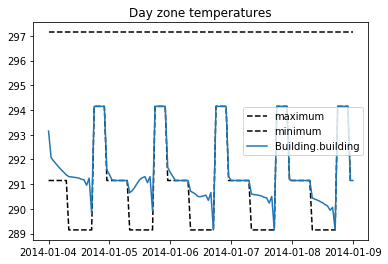

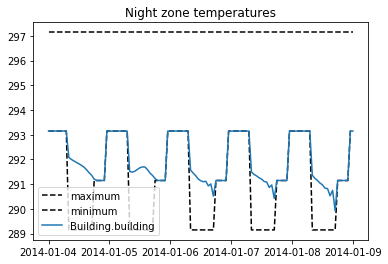

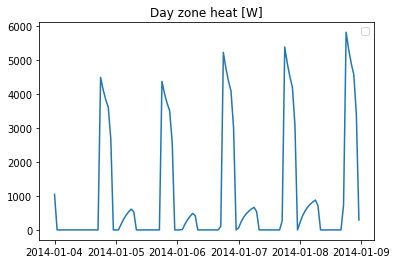

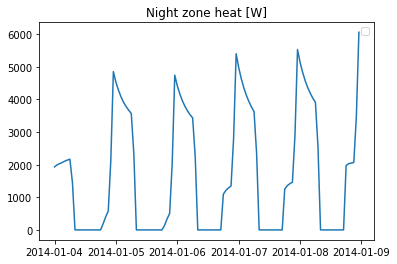

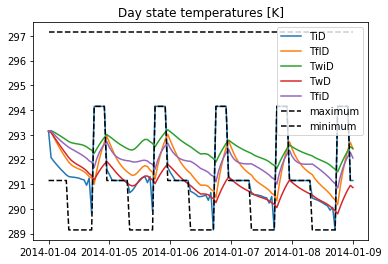

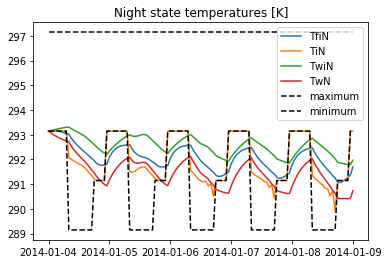

In [74]:


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# ax1 = fig1.add_subplot(221)
ax1.plot(day_max, label='maximum', linestyle='--', color='k')
ax1.plot(day_min, label='minimum', linestyle='--', color='k')
ax1.plot(TiD, label='Building.building')
ax1.legend()
ax1.set_title('Day zone temperatures')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(night_max, label='maximum', linestyle='--', color='k')
ax2.plot(night_min, label='minimum', linestyle='--', color='k')
ax2.plot(TiN, label='Building.building')
ax2.legend()
ax2.set_title('Night zone temperatures')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(Q_hea_D)
ax3.legend()
ax3.set_title('Day zone heat [W]')

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(Q_hea_N)
ax4.legend()
ax4.set_title('Night zone heat [W]')

fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(TiD, label='TiD')
ax5.plot(TflD, label='TflD')
ax5.plot(TwiD, label='TwiD')
ax5.plot(TwD, label='TwD')
ax5.plot(TfiD, label='TfiD')
ax5.plot(day_max, label='maximum', linestyle='--', color='k')
ax5.plot(day_min, label='minimum', linestyle='--', color='k')
ax5.legend()
ax5.set_title('Day state temperatures [K]')

fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.plot(TfiN, label='TfiN')
ax6.plot(TiN, label='TiN')
ax6.plot(TwiN, label='TwiN')
ax6.plot(TwN, label='TwN')
ax6.plot(night_max, label='maximum', linestyle='--', color='k')
ax6.plot(night_min, label='minimum', linestyle='--', color='k')
ax6.legend()
ax6.set_title('Night state temperatures [K]')



## Storage unit

In [77]:
storage_stored_heat = optmodel.get_result('heat_stor', node='BuildingAndStorage',
                                  comp='storage')
storage_heat_flow = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')

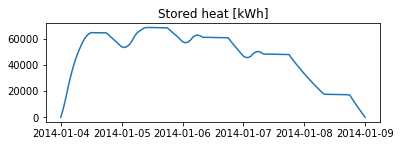

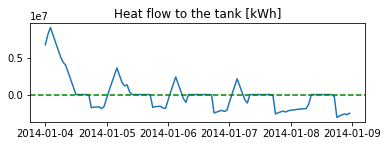

In [81]:
fig1 = plt.figure()
ax = fig1.add_subplot(211)
ax.plot(storage_stored_heat)
ax.set_title('Stored heat [kWh]')

fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.plot(storage_heat_flow)
ax2.set_title('Heat flow to the tank [kWh]')
ax2.axhline(linestyle='--', color='g')

## Heat generation unit

## Network efficiency

In [ ]:
# Heat flows
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
storage_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')
waterschei_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                    comp='building')
zwartberg_hf = optmodel.get_result('heat_flow', node='Building',
                                   comp='building')


# Sum of heat flows
prod_e = sum(prod_hf)
storage_e = sum(storage_hf)
waterschei_e = sum(waterschei_hf)
zwartberg_e = sum(zwartberg_hf)

# Efficiency
print '\nNetwork'
print 'Efficiency', (storage_e + waterschei_e + zwartberg_e) / prod_e * 100, '%'

    

    

In [ ]:
fig = plt.figure()

    ax = fig.add_subplot(211)

    ax.plot(prod_hf, label='Producer')
    ax.plot(waterschei_hf + storage_hf + zwartberg_hf, label='Users and storage')  # , )])  #
    ax.axhline(y=0, linewidth=2, color='k', linestyle='--')
    ax.set_title('Heat flows [W]')
    ax.legend()

    c_f = ut.read_period_data(path='../Data/ElectricityPrices',
                              name='DAM_electricity_prices-2014_BE.csv',
                              time_step=time_step, horizon=n_steps * time_step,
                              start_time=start_time)['price_BE']

    ax1 = fig.add_subplot(212)
    ax1.plot(c_f, label='Fuel price (electricity) euro/MWh')
    ax1.set_title('Price')
    ax1.legend()
    fig.tight_layout()

    

    fig3 = plt.figure()

    ax3 = fig3.add_subplot(111)
    ax3.plot(waterschei_hf, label='Waterschei')
    ax3.plot(zwartberg_hf, label="Zwartberg")
    ax3.plot(storage_hf, linestyle='--', label='Storage')
    ax3.axhline(y=0, linewidth=1.5, color='k', linestyle='--')
    ax3.legend()
    ax3.set_ylabel('Heat Flow [W]')
    #ax3.tight_layout()

    fig4 = plt.figure()


    day_max = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                                  time_step=time_step, horizon=n_steps*time_step, start_time=start_time)['day_max']
    day_min = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                                  time_step=time_step, horizon=n_steps*time_step, start_time=start_time)['day_min']
    night_max = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                                    time_step=time_step, horizon=n_steps*time_step, start_time=start_time)['night_max']
    night_min = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                                    time_step=time_step, horizon=n_steps*time_step, start_time=start_time)['night_min']

    ax4 = fig4.add_subplot(221)
    ax4.plot(day_max, label='maximum', linestyle='--', color='k')
    ax4.plot(day_min, label='minimum', linestyle='--', color='k')
    ax4.plot(TiD_ws, label='Waterschei')
    ax4.plot(TiD_zw, label="Zwartberg")
    ax4.legend()
    ax4.set_ylabel('Day zone temperatures')

    ax5 = fig4.add_subplot(222)

    ax4.plot(night_max, label='maximum', linestyle='--', color='k')
    ax4.plot(night_min, label='minimum', linestyle='--', color='k')
    ax5.plot(TiN_ws, label='Waterschei')
    ax5.plot(TiN_zw, label="Zwartberg")
    ax5.legend()
    ax5.set_ylabel('Night zone temperatures')

    ax4 = fig4.add_subplot(223)
    ax4.plot(Q_hea_D_ws, label='Waterschei')
    ax4.plot(Q_hea_D_zw, label="Zwartberg")
    ax4.legend()
    ax4.set_ylabel('Day zone heat [W]')

    ax5 = fig4.add_subplot(224)
    ax5.plot(Q_hea_N_ws, label='Waterschei')
    ax5.plot(Q_hea_N_zw, label="Zwartberg")
    ax5.legend()
    ax5.set_ylabel('Night zone heat [W]')
    #ax3.tight_layout()

    fig5 = plt.figure()

    ax5 = fig5.add_subplot(211)
    ax5.plot(TiD_zw, label='TiD')
    ax5.plot(TflD_zw, label='TflD')
    ax5.plot(TwiD_zw, label='TwiD')
    ax5.plot(TwD_zw, label='TwD')
    ax5.plot(TfiD_zw, label='TfiD')
    ax5.plot(day_max, label='maximum', linestyle='--', color='k')
    ax5.plot(day_min, label='minimum', linestyle='--', color='k')
    ax5.legend()
    ax5.set_ylabel('State temperatures [W]')
    ax6 = fig5.add_subplot(212)
    ax6.plot(TfiN_zw, label='TfiN')
    ax6.plot(TiN_zw, label='TiN')
    ax6.plot(TwiN_zw, label='TwiN')
    ax6.plot(TwN_zw, label='TwN')
    ax6.plot(night_max, label='maximum', linestyle='--', color='k')
    ax6.plot(night_min, label='minimum', linestyle='--', color='k')
    ax6.legend()
    ax6.set_ylabel('State temperatures [W]')


    plt.show()